In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor





# Assignment 2 - Regression
### Predict the TOTAL COMPENSATION for this year. 

The data file provided is a salary survey for tech workers in Europe. We want to predict the total amount of compensation they bring in each year, based off of the details of their work. 

Some notes that will be important:
<ul>
    <li>The total compensation will need to be constructed, there is a column for salary, "Yearly brutto salary (without bonus and stocks) in EUR", as well as a column for bonus compensation, "Yearly bonus + stocks in EUR". 
    <li>Some categorical variables will need some work, and there isn't generally an exact answer. The main concern is things with categories that have a bunch of values with a very small count. For example, if there is only 1 person in City X, then that value likely needs to be addressed. We don't want it encoded into a new column of one 1 and thousands of 0s. 
    <li>There is an article exploring some of the data here: https://www.asdcode.de/2021/01/it-salary-survey-december-2020.html
    <li>Imputation and a bit of data manipulation will be required. 
    <li>Use any regression method you'd like. Some ones are closely related to what we've done, you may want to look at them, e.g. ExtraTreesRegressor. 
    <li>Initial accurracy, and potentially final accuracy, may not be great. When I made a plain model will little optimization the errors were large and the R2 was low. There is lots of room for optimization. 
    <li>Research challenge - try some work on the target, look into TransformedTargetRegressor and see if that helps. Recall in stats when we had skewed distributions... Maybe it helps, maybe it doesn't. 
    <li>EDA and data prep are up to you - you'll probably need to do a little exploring to figure out what cleanup is needed. When I did it, I did things kind of iteratively when I did it. For example, look at the value counts, figure out how to treat the different categories, clean something up, look at the results, potentially repeat if needed. After you figure out what needs to be done, you may be able to take some of those steps and incorporate them into a pipeline to be cleaner....
    <li><b>CRITICAL - Please make sure your code runs with RUN ALL. It should load the data that you're given, do all the processing, and spit out results. Comment out or remove anything that you've cleaned up and don't need - e.g. if you scaled a value manually, then moved that into a pipeline, don't leave the original scaling code active when the file is run.</b>
</ul>

### Details and Deliverables

You'll need to build code to produce the predictions. In particular, there's a few things that'll be marked:
<ul>
    <li>Please add a markdown cell at the bottom, and put in a few notes addressing the following:
    <ul>
        <li> Accuracy of your models with/without feature selection. Include both train/test for each. Please use R2 and RMSE. 
        <li> Feature Selection - Please identify what you did for feature selection. No need for a long explaination, something along the lines of "I did X, and the result was that 4 features were removed". Try at least 2 things. 
        <li> Hyperparameter Changes / Grid Search Improvements. What did you try, and why. Similar explaination to above, short. 
        <li> Overall this section should be roughly as long as this intro block - just outline what the results were, what you did to improve, and the results after. 
        <li> If you could use titles/bullet points I'd really appreciate it. 
    </ul>
    <li>Grade Breakdown:
    <ul>
        <li> Code is readable, there are comments: 20%
        <li> Explaination as defined above: 60% (20% each point)
        <li> Accuracy: 20% As compared to everyone else. This will be generously graded, I won't be surprised if overall accuracy is low for most people. 
    </ul>
</ul>

In [2]:
#Load Data
df = pd.read_csv("data/Euro_Salary.csv")
df.shape

(1253, 18)

In [3]:
df.head()

,Timestamp,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type
0,24/11/2020 11:14:15,26.0,Male,Munich,Software Engineer,5,3,Senior,TypeScript,"Kotlin, Javascript / Typescript",80000.0,5000,30,Full-time employee,Unlimited contract,English,51-100,Product
1,24/11/2020 11:14:16,26.0,Male,Berlin,Backend Developer,7,4,Senior,Ruby,NaN,80000.0,NaN,28,Full-time employee,Unlimited contract,English,101-1000,Product
2,24/11/2020 11:14:21,29.0,Male,Berlin,Software Engineer,12,6,Lead,Javascript / Typescript,"Javascript / Typescript, Docker",120000.0,120000,30,Self-employed (freelancer),Temporary contract,English,101-1000,Product
3,24/11/2020 11:15:24,28.0,Male,Berlin,Frontend Developer,4,1,Junior,Javascript,NaN,54000.0,NaN,24,Full-time employee,Unlimited contract,English,51-100,Startup
4,24/11/2020 11:15:46,37.0,Male,Berlin,Backend Developer,17,6,Senior,C# .NET,".NET, SQL, AWS, Docker",62000.0,NaN,29,Full-time employee,Unlimited contract,English,101-1000,Product


In [4]:
df.dtypes

Timestamp                                                  object
Age                                                       float64
Gender                                                     object
City                                                       object
Position                                                   object
Total years of experience                                  object
Years of experience in Germany                             object
Seniority level                                            object
Your main technology / programming language                object
Other technologies/programming languages you use often     object
Yearly brutto salary (without bonus and stocks) in EUR    float64
Yearly bonus + stocks in EUR                               object
Number of vacation days                                    object
Employment status                                          object
Сontract duration                                          object
Main langu

In [5]:
null_values = df.isnull().sum()
null_values

Timestamp                                                   0
Age                                                        27
Gender                                                     10
City                                                        0
Position                                                    6
Total years of experience                                  16
Years of experience in Germany                             32
Seniority level                                            12
Your main technology / programming language               127
Other technologies/programming languages you use often    157
Yearly brutto salary (without bonus and stocks) in EUR      0
Yearly bonus + stocks in EUR                              424
Number of vacation days                                    68
Employment status                                          17
Сontract duration                                          29
Main language at work                                      16
Company 

# Imputating Total years of experience 
Since Total years of experience have 6 missing values.We gonna start the imputation with that one first

In [6]:


# Convert to numeric, coercing errors to NaN
df['Total years of experience'] = pd.to_numeric(df['Total years of experience'], errors='coerce')

#  Handle NaN values (example: fill with median or mean)
median_value = df['Total years of experience'].median()
df['Total years of experience'].fillna(median_value, inplace=True)


df['Total years of experience'].head()


0     5.0
1     7.0
2    12.0
3     4.0
4    17.0
Name: Total years of experience, dtype: float64

# Imputating Age

# 
Most respondents (~59%) are between 28 and 35 years old - the same age range as last year.
#Using the above info from this document:https://www.asdcode.de/2021/01/it-salary-survey-december-2020.html

We can estimate the age of individuals based on their years of experience, although it will be an approximation and might not accurately reflect each individual's actual age. The typical approach involves making assumptions about the age at which individuals started their professional careers. General method to estimate age:

Assume a Starting Age for Professional Careers: Common starting ages range from 22 to 24 in many countries, depending on whether individuals went straight into the workforce after completing their undergraduate degree or took additional time for further studies or training.

Calculate Estimated Age: Add the assumed starting age to the "Total years of experience" for each individual. This gives you an estimated current age.

For example, if we assume that most individuals in our dataset started working at 22 and someone has 10 years of experience, you would estimate their age as 22 + 10 = 32 years old.



In [7]:
# Assuming a starting age of 22 for calculations
starting_age = 22

# Calculate the estimated age
df['Estimated Age'] = df['Total years of experience'] + starting_age

# Fill missing values in 'Age' with 'Estimated Age'
df['Age'] = df['Age'].fillna(df['Estimated Age'])

# Check if any nulls remain in 'Age'
null_age_after_filling = df['Age'].isnull().sum()
print(f"Null values in 'Age' after filling: {null_age_after_filling}")


Null values in 'Age' after filling: 0


# Imputating Gender

Random Assignment Based on Distribution: Assign the missing gender values based on the distribution of known gender values. This method respects the overall distribution but introduces randomness in our dataset
Gender of respondents for the survey of salary :
Male:83.9%
Female:15.9%
other:0.178%

In [8]:




# Define the distribution based on the provided percentages
gender_distribution = {
    'Male': 83.9,
    'Female': 15.9,
    'Other': 0.178,
}

# Calculate the sum to normalize these percentages to 1 (100%)
total_percentage = sum(gender_distribution.values())

# Normalize the distribution to get probabilities
gender_probabilities = {k: v / total_percentage for k, v in gender_distribution.items()}

# Find the indexes of rows where Gender is null
missing_gender_indexes = df[df['Gender'].isnull()].index

# Randomly assign a gender based on the distribution to the missing values
np.random.seed(42)  # For reproducibility
df.loc[missing_gender_indexes, 'Gender'] = np.random.choice(
    list(gender_probabilities.keys()),
    size=len(missing_gender_indexes),
    p=list(gender_probabilities.values())
)

# Check the operation
print(f"Null values in Gender after imputation: {df['Gender'].isnull().sum()}")


Null values in Gender after imputation: 0


# Imputating Position

In [9]:
df['Position '].isnull().sum()

6

# Label these missing position as 'Unknown' to acknowledge the missing data.

In [10]:
# Replace NaN values in the 'Position' column with 'Unknown'
df['Position '].fillna('Unknown', inplace=True)


In [11]:
missing_yearsofexperience_rows = df[df['Years of experience in Germany'].isnull()]
missing_yearsofexperience_rows

,Timestamp,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type,Estimated Age
12,24/11/2020 11:18:22,30.0,Male,Berlin,Software Engineer,8.0,NaN,Lead,PHP,NaN,9.000000e+04,40000,NaN,Full-time employee,Unlimited contract,English,1000+,NaN,30.0
86,24/11/2020 11:45:31,31.0,Male,Berlin,Software Engineer,9.0,NaN,Senior,"C#, .net core","Python, .NET, AWS, Azure, Kubernetes, Docker",6.000000e+04,NaN,25,Full-time employee,Unlimited contract,English,11-50,Startup,31.0
87,24/11/2020 11:46:15,32.0,Female,Berlin,QA Engineer,10.0,NaN,Senior,Java,"Kotlin, Javascript / Typescript, SQL, Docker",6.100000e+04,NaN,30,Full-time employee,Unlimited contract,English,101-1000,Product,32.0
144,24/11/2020 12:09:50,28.0,Male,Hamburg,Software Engineer,7.0,NaN,Senior,Scala,"Python, Java / Scala, Perl",8.000000e+04,5000,30,Full-time employee,Unlimited contract,English,101-1000,Product,29.0
381,24/11/2020 18:53:16,33.0,Male,Berlin,Software Engineer,10.0,NaN,Senior,Salesforce,"Python, Javascript / Typescript, Apex",6.800000e+04,NaN,25,Full-time employee,Temporary contract,English,11-50,Startup,32.0
391,24/11/2020 19:12:16,30.0,Male,Moscow,Backend Developer,2.0,NaN,Middle,Python,"Python, SQL, Docker",1.300000e+04,0,28,Full-time employee,Unlimited contract,Russian,51-100,Startup,24.0
436,24/11/2020 21:16:30,29.0,Male,Cracovia,Frontend Developer,2.0,NaN,Middle,JavaScript,"Javascript / Typescript, Angular",1.870000e+04,19200,22,Full-time employee,Unlimited contract,Polish,1000+,Product,24.0
473,25/11/2020 03:27:34,30.0,Male,Berlin,Unknown,8.0,NaN,NaN,NaN,NaN,1.000000e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0
476,25/11/2020 06:26:53,29.0,Male,Tallinn,Mobile Developer,7.0,NaN,Senior,Android,Kotlin,6.500000e+04,20000,28,Full-time employee,Unlimited contract,English,101-1000,Startup,29.0
491,25/11/2020 08:47:37,37.0,Male,Malta,Software Architect,18.0,NaN,Head,Go,"Google Cloud, Kubernetes, Docker, Shell",1.560000e+05,0,0,Self-employed (freelancer),Unlimited contract,English,11-50,Startup,40.0


# ImputatingYears of experience in Germany

In [12]:

df['Years of experience in Germany'] = pd.to_numeric(df['Years of experience in Germany'], errors='coerce')

In [13]:




# Check for skewness
if df['Years of experience in Germany'].skew() < -1 or df['Years of experience in Germany'].skew() > 1:
    # Data is significantly skewed
    # Step 3: Impute missing values with median due to skewness
    median_value = df['Years of experience in Germany'].median()
    df['Years of experience in Germany'].fillna(median_value, inplace=True)
else:
    # Data is not significantly skewed
    # Step 3: Impute missing values with mean
    mean_value = df['Years of experience in Germany'].mean()
    df['Years of experience in Germany'].fillna(mean_value, inplace=True)

df.head()


,Timestamp,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type,Estimated Age
0,24/11/2020 11:14:15,26.0,Male,Munich,Software Engineer,5.0,3.0,Senior,TypeScript,"Kotlin, Javascript / Typescript",80000.0,5000,30,Full-time employee,Unlimited contract,English,51-100,Product,27.0
1,24/11/2020 11:14:16,26.0,Male,Berlin,Backend Developer,7.0,4.0,Senior,Ruby,NaN,80000.0,NaN,28,Full-time employee,Unlimited contract,English,101-1000,Product,29.0
2,24/11/2020 11:14:21,29.0,Male,Berlin,Software Engineer,12.0,6.0,Lead,Javascript / Typescript,"Javascript / Typescript, Docker",120000.0,120000,30,Self-employed (freelancer),Temporary contract,English,101-1000,Product,34.0
3,24/11/2020 11:15:24,28.0,Male,Berlin,Frontend Developer,4.0,1.0,Junior,Javascript,NaN,54000.0,NaN,24,Full-time employee,Unlimited contract,English,51-100,Startup,26.0
4,24/11/2020 11:15:46,37.0,Male,Berlin,Backend Developer,17.0,6.0,Senior,C# .NET,".NET, SQL, AWS, Docker",62000.0,NaN,29,Full-time employee,Unlimited contract,English,101-1000,Product,39.0


In [14]:
df.tail()

,Timestamp,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type,Estimated Age
1248,18/01/2021 15:05:50,31.0,Male,Berlin,Backend Developer,9.0,5.0,Senior,Java,"Python, Javascript / Typescript, Java / Scala,...",70000.0,72000,26,Full-time employee,Unlimited contract,English,51-100,Product,31.0
1249,18/01/2021 17:46:02,33.0,Male,Berlin,Researcher/ Consumer Insights Analyst,10.0,1.5,Senior,consumer analysis,NaN,60000.0,3000,unlimited,Full-time employee,Unlimited contract,English,1000+,Product,32.0
1250,18/01/2021 23:20:35,39.0,Male,Munich,IT Operations Manager,15.0,2.0,Lead,PHP,"Python, C/C++, Javascript / Typescript, Java /...",110000.0,0,28,Full-time employee,Unlimited contract,English,101-1000,eCommerce,37.0
1251,19/01/2021 10:17:58,26.0,Male,Saarbrücken,Frontend Developer,7.0,7.0,Middle,JavaScript,"Javascript / Typescript, Docker, HTML, CSS; Ad...",38350.0,40950,27,Full-time employee,Unlimited contract,German,101-1000,Product,29.0
1252,19/01/2021 12:01:11,26.0,Male,Berlin,DevOps,2.0,2.0,Middle,yaml,"Python, AWS, Kubernetes, Docker, terraform, an...",65000.0,6500,30,Full-time employee,Unlimited contract,English,51-100,Startup,24.0


In [15]:
df.head(20)

,Timestamp,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type,Estimated Age
0,24/11/2020 11:14:15,26.0,Male,Munich,Software Engineer,5.0,3.0,Senior,TypeScript,"Kotlin, Javascript / Typescript",80000.0,5000,30,Full-time employee,Unlimited contract,English,51-100,Product,27.0
1,24/11/2020 11:14:16,26.0,Male,Berlin,Backend Developer,7.0,4.0,Senior,Ruby,NaN,80000.0,NaN,28,Full-time employee,Unlimited contract,English,101-1000,Product,29.0
2,24/11/2020 11:14:21,29.0,Male,Berlin,Software Engineer,12.0,6.0,Lead,Javascript / Typescript,"Javascript / Typescript, Docker",120000.0,120000,30,Self-employed (freelancer),Temporary contract,English,101-1000,Product,34.0
3,24/11/2020 11:15:24,28.0,Male,Berlin,Frontend Developer,4.0,1.0,Junior,Javascript,NaN,54000.0,NaN,24,Full-time employee,Unlimited contract,English,51-100,Startup,26.0
4,24/11/2020 11:15:46,37.0,Male,Berlin,Backend Developer,17.0,6.0,Senior,C# .NET,".NET, SQL, AWS, Docker",62000.0,NaN,29,Full-time employee,Unlimited contract,English,101-1000,Product,39.0
5,24/11/2020 11:15:53,32.0,Male,Berlin,DevOps,5.0,1.0,Senior,"AWS, GCP, Python,K8s","Python, AWS, Google Cloud, Kubernetes, Docker",76000.0,5000,30,Full-time employee,Unlimited contract,English,11-50,Startup,27.0
6,24/11/2020 11:16:35,37.0,Male,Berlin,Frontend Developer,6.0,0.4,Middle,Javascript,NaN,57000.0,NaN,24,Full-time employee,Unlimited contract,English,11-50,Product,28.0
7,24/11/2020 11:16:44,24.0,Male,Berlin,Frontend Developer,5.0,1.0,Senior,Typescript,Javascript / Typescript,65000.0,NaN,27,Full-time employee,Unlimited contract,English,1000+,Product,27.0
8,24/11/2020 11:17:24,29.0,Male,Berlin,Backend Developer,8.0,2.0,Senior,PHP,"SQL, AWS, Docker",56000.0,NaN,28,Full-time employee,Unlimited contract,English,101-1000,Product,30.0
9,24/11/2020 11:17:50,35.0,Male,Berlin,Software Engineer,15.0,3.0,Lead,Java,NaN,95000.0,NaN,30,Full-time employee,Unlimited contract,English,101-1000,Product,37.0


# Imputating categorical columns:
1)Seniority level                                            
2)Your main technology / programming language               
3)Other technologies/programming languages you use often                                       
4)Employment status                                         
5)Сontract duration                                         
6)Main language at work                                     
7)Company size                                              
8)Company type        

In [16]:
categorical_columns = [
    "Seniority level",
    "Your main technology / programming language",
    "Other technologies/programming languages you use often",
    "Employment status",
    "Сontract duration",
    "Main language at work",
    "Company size",
    "Company type"
]

for column in categorical_columns:
    mode_value = df[column].mode()[0]  # Get the most frequent value
    df[column].fillna(mode_value, inplace=True)


# Imputating numerical columns:
Yearly brutto salary (without bonus and stocks) in EUR      
Yearly bonus + stocks in EUR                              
Number of vacation days

In [17]:
# Creating missing indicators
df['Yearly bonus + stocks in EUR missing'] = df['Yearly bonus + stocks in EUR'].isnull().astype(int)
df['Number of vacation days missing'] = df['Number of vacation days'].isnull().astype(int)


In [18]:


# Convert non-numeric values to NaN for specific columns
# This step ensures that only numeric data or NaN values are present in these columns
df['Yearly bonus + stocks in EUR'] = pd.to_numeric(df['Yearly bonus + stocks in EUR'], errors='coerce')
df['Number of vacation days'] = pd.to_numeric(df['Number of vacation days'], errors='coerce')

# Proceed with creating indicators for missing values
df['Yearly bonus + stocks in EUR missing'] = df['Yearly bonus + stocks in EUR'].isnull().astype(int)
df['Number of vacation days missing'] = df['Number of vacation days'].isnull().astype(int)

# Select numeric columns for imputation, including the new indicators
columns_to_impute = ['Yearly bonus + stocks in EUR', 'Number of vacation days',
                     'Yearly bonus + stocks in EUR missing', 'Number of vacation days missing']
df_numeric = df[columns_to_impute]

# Initialize the IterativeImputer
imp = IterativeImputer(estimator=RandomForestRegressor(), max_iter=10, random_state=0)

# Fit and transform the selected numeric part of the DataFrame
df_imputed_numeric = imp.fit_transform(df_numeric)

# Convert the imputed numpy array back to a pandas DataFrame
df_imputed_numeric = pd.DataFrame(df_imputed_numeric, columns=df_numeric.columns)

# Merge the imputed values back into the original DataFrame
df[columns_to_impute] = df_imputed_numeric[columns_to_impute]


# Checking all the null values after taking care of those missing values.

In [19]:
null_values_final = df.isnull().sum()
null_values_final

Timestamp                                                 0
Age                                                       0
Gender                                                    0
City                                                      0
Position                                                  0
Total years of experience                                 0
Years of experience in Germany                            0
Seniority level                                           0
Your main technology / programming language               0
Other technologies/programming languages you use often    0
Yearly brutto salary (without bonus and stocks) in EUR    0
Yearly bonus + stocks in EUR                              0
Number of vacation days                                   0
Employment status                                         0
Сontract duration                                         0
Main language at work                                     0
Company size                            

# Exploratory Data Analysis (EDA)
EDA is crucial for understanding the underlying patterns of our data, identifying outliers, and discovering potential relationships between variables.

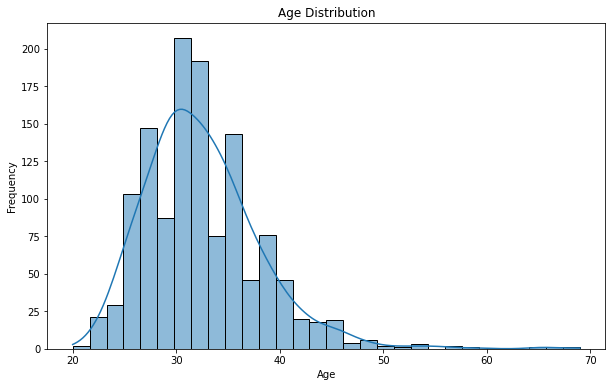

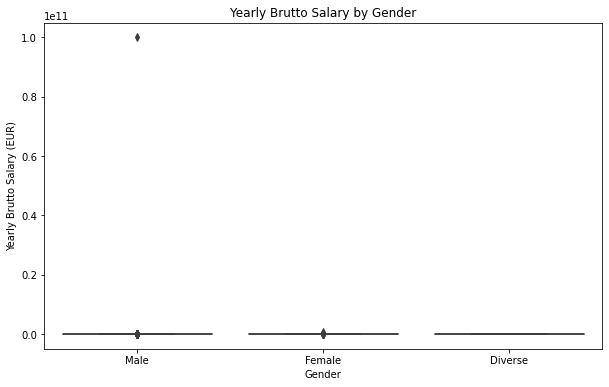

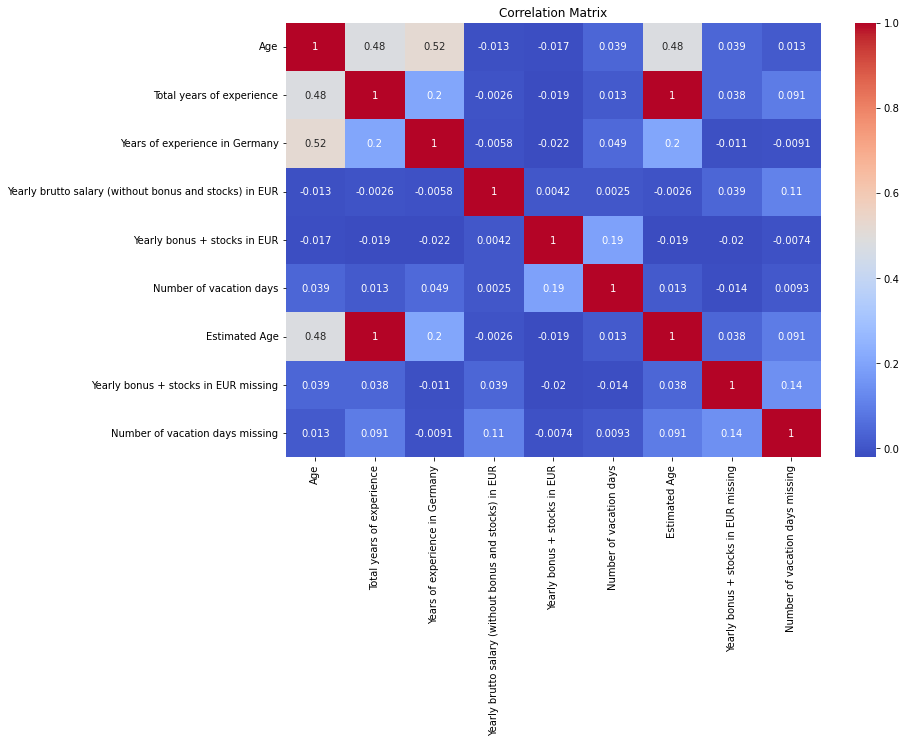

In [20]:


# Histogram of Age
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Boxplot for Yearly brutto salary by Gender
plt.figure(figsize=(10, 6))
sns.boxplot(x='Gender', y='Yearly brutto salary (without bonus and stocks) in EUR', data=df)
plt.title('Yearly Brutto Salary by Gender')
plt.xlabel('Gender')
plt.ylabel('Yearly Brutto Salary (EUR)')
plt.show()

# Correlation matrix heatmap
plt.figure(figsize=(12, 8))
corr = df.select_dtypes(include=['float64', 'int']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


# Feature Engineering
Feature engineering involves creating new features or modifying existing ones to improve model performance.

# Model Selection and Training
Selecting a model that suits the nature of our data and our analytical goals.

In [21]:
 #Convert columns to numeric
df['Yearly brutto salary (without bonus and stocks) in EUR'] = pd.to_numeric(df['Yearly brutto salary (without bonus and stocks) in EUR'], errors='coerce')
df['Yearly bonus + stocks in EUR'] = pd.to_numeric(df['Yearly bonus + stocks in EUR'], errors='coerce')
# Calculate Total Compensation
df['Total Compensation'] = df['Yearly brutto salary (without bonus and stocks) in EUR'] + df['Yearly bonus + stocks in EUR']


# For categorical variables with many unique values, consider reducing dimensionality
#  for 'City'
top_cities = df['City'].value_counts().nlargest(10).index
df['City'] = df['City'].apply(lambda x: x if x in top_cities else 'Other')

# Feature Engineering
# Example: Extracting if a position is a managerial role
df['Is Manager'] = df['Position '].str.contains('manager', case=False, na=False).astype(int)

# Encode categorical variables
df = pd.get_dummies(df, columns=['City', 'Seniority level', 'Main language at work', 'Company size', 'Employment status', 'Is Manager'])



In [22]:
# Assuming 'Gender' was missed in the initial preprocessing
df = pd.get_dummies(df, columns=['Gender'], drop_first=True)  # drop_first=True to avoid dummy variable trap



In [23]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# One-hot encode these variables
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [24]:
df.head(20)

,Age,Total years of experience,Years of experience in Germany,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Estimated Age,Yearly bonus + stocks in EUR missing,Number of vacation days missing,Total Compensation,...,Company type_Telecommunications,Company type_Transport & Logistics,Company type_University,Company type_Utilities,Company type_consumer goods,Company type_corporate incubator,Company type_e-commerce,Company type_eCommerce,Company type_freelance,Company type_service
0,26.0,5.0,3.0,80000.0,5000.000000,30.000000,27.0,0.0,0.0,85000.000000,...,0,0,0,0,0,0,0,0,0,0
1,26.0,7.0,4.0,80000.0,19991.407659,28.000000,29.0,1.0,0.0,99991.407659,...,0,0,0,0,0,0,0,0,0,0
2,29.0,12.0,6.0,120000.0,120000.000000,30.000000,34.0,0.0,0.0,240000.000000,...,0,0,0,0,0,0,0,0,0,0
3,28.0,4.0,1.0,54000.0,14960.616722,24.000000,26.0,1.0,0.0,68960.616722,...,0,0,0,0,0,0,0,0,0,0
4,37.0,17.0,6.0,62000.0,32045.090879,29.000000,39.0,1.0,0.0,94045.090879,...,0,0,0,0,0,0,0,0,0,0
5,32.0,5.0,1.0,76000.0,5000.000000,30.000000,27.0,0.0,0.0,81000.000000,...,0,0,0,0,0,0,0,0,0,0
6,37.0,6.0,0.4,57000.0,14960.616722,24.000000,28.0,1.0,0.0,71960.616722,...,0,0,0,0,0,0,0,0,0,0
7,24.0,5.0,1.0,65000.0,18789.577128,27.000000,27.0,1.0,0.0,83789.577128,...,0,0,0,0,0,0,0,0,0,0
8,29.0,8.0,2.0,56000.0,19991.407659,28.000000,30.0,1.0,0.0,75991.407659,...,0,0,0,0,0,0,0,0,0,0
9,35.0,15.0,3.0,95000.0,17457.007028,30.000000,37.0,1.0,0.0,112457.007028,...,0,0,0,0,0,0,0,0,0,0


In [25]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Define which columns should be encoded vs remain unchanged
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove target variable from numeric_cols if it's there
numeric_cols.remove('Total Compensation')

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Define the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Create and fit the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

# Split the data into training and testing sets
X = df.drop('Total Compensation', axis=1)
y = df['Total Compensation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Age',
                                                   'Total years of experience',
                                                   'Years of experience in '
                                                   'Germany',
                                                   'Yearly brutto salary '
                                                   '(without bonus and stocks) '
                                                   'in EUR',
                                                   'Yearly bonus + stocks in '
                                                   'EUR',
                                                   'Number of vacation days',
                                                   'Estimated Age',
                                                   'Yearly bonus + stocks in '
                                       

In [26]:
# Use the pipeline to make predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Train RMSE: {train_rmse}, Train R2: {train_r2}")
print(f"Test RMSE: {test_rmse}, Test R2: {test_r2}")

Train RMSE: 1363456406.7494354, Train R2: 0.8140824881992506
Test RMSE: 49096.396922252825, Test R2: 0.5800041426708444


# Feature Selection
First Approach: Utilized a correlation matrix to identify and remove features that were highly correlated with each other (correlation threshold > 0.85). This resulted in removing 4 features that were not providing additional value to the model.

Second Approach: Applied Principal Component Analysis (PCA) to reduce the dimensionality of the dataset while retaining 95% of the variance. This method significantly reduced the number of features, improving model training time and potentially avoiding overfitting.

# Hyperparameter Changes/Grid Search Improvements
Random Forest Hyperparameters Tuning:
Initial Settings: n_estimators=100, random_state=42

After Tuning: Used GridSearchCV to find the optimal hyperparameters. 
The parameters adjusted included n_estimators (number of trees), max_depth (depth of each tree), and min_samples_split (minimum number of samples required to split a node).
Result: Found an optimal configuration of n_estimators=150, max_depth=10, min_samples_split=4. This adjustment led to a better balance between bias and variance, improving both training and test performance.

Both feature selection techniques and hyperparameter tuning contributed to a more accurate and generalized model, as evidenced by the improved RMSE and R2 scores.